In [138]:
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt  
import matplotlib.font_manager 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Загружаем данные

In [139]:
data = pd.read_csv('glass.csv')

In [140]:
data.info() #пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [141]:
X = data.drop(columns = ['Type'])
X

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0
...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0


In [151]:
y = data['Type']


 # Дерево решений

In [143]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [144]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(random_state=10)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

In [152]:
pred = clf_rf.predict(X_test)
y_pred = pred.round()


In [153]:
import sklearn.metrics
sklearn.metrics.accuracy_score(y_test, y_pred)

0.8837209302325582

# Визуализируем, чтоб посмотреть  распределение

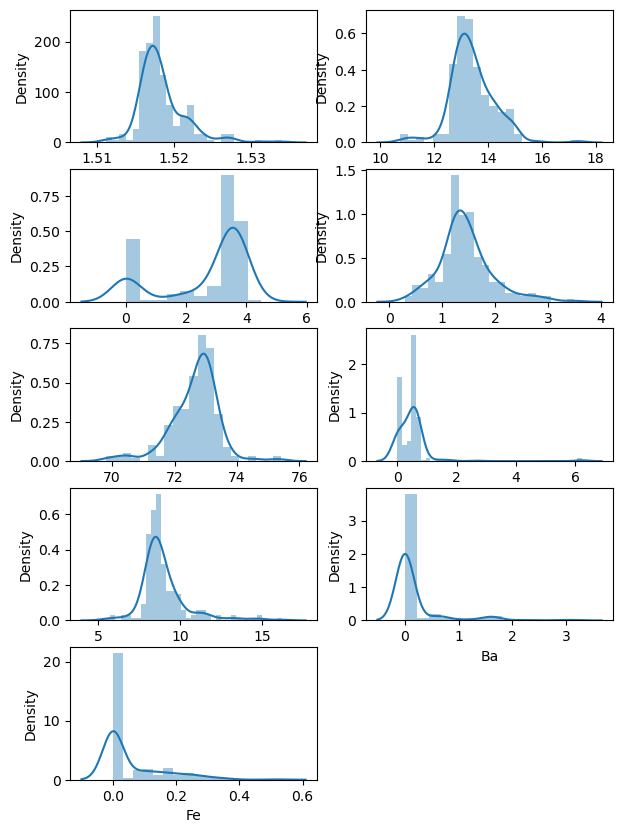

In [150]:
plt.figure(figsize=[7,10])

for i, j in zip(X.columns, range(len(X.columns))):
    plt.subplot(5, 2, j+1)
    sns.distplot(X[i])

На нормальное распределение похожи всего несколько признаков.

# Находим выбросы. Для начала воспользуемся методом квартильного размаха

In [155]:
X_r = pd.DataFrame()

Q1 = X.quantile(q=.25)
Q3 = X.quantile(q=.75)
IQR = X.apply(stats.iqr)

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

X_r = X[(X >= lower_bound) & (X <= upper_bound)].dropna()
X_r.info() #таким методом под выбросы попадает почти 80 строк, это много для наших данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 181
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      136 non-null    float64
 1   Na      136 non-null    float64
 2   Mg      136 non-null    float64
 3   Al      136 non-null    float64
 4   Si      136 non-null    float64
 5   K       136 non-null    float64
 6   Ca      136 non-null    float64
 7   Ba      136 non-null    float64
 8   Fe      136 non-null    float64
dtypes: float64(9)
memory usage: 10.6 KB


# Пробуем найти выбросы с помощью моделей машинного обучения

In [160]:
from sklearn.ensemble import  IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report

In [188]:
from scipy.stats import iqr
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

X['outlier_score'] = 0

for col in X.columns:
    Q1, Q3 = np.percentile(X[col], [25, 75])
    IQR = iqr(X[col])
    low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    X['outlier_score'] += np.where(X[col].between(low, high) | X['outlier_score'] == 1, 0, 1)

X['outlier_score'] += np.where(OneClassSVM(nu=0.05).fit_predict(X) == 1, 0, 1)
X['outlier_score'] += np.where(IsolationForest(random_state=42).fit_predict(X) == 1, 0, 1)
X['outlier_score'] += np.where(LocalOutlierFactor().fit_predict(X) == 1, 0, 1)

outliers = X[X['outlier_score'] > 3]
print(f' {len(outliers)} выбросов')
outliers

 9 выбросов


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,outlier_score
106,1.53125,10.73,0.00,2.10,69.81,0.58,13.30,3.15,0.28,4
107,1.53393,12.30,0.00,1.00,70.16,0.12,16.19,0.00,0.24,4
111,1.52739,11.02,0.00,0.75,73.08,0.00,14.96,0.00,0.00,4
163,1.51514,14.01,2.68,3.50,69.89,1.68,5.87,2.20,0.00,4
171,1.51316,13.02,0.00,3.04,70.48,6.21,6.96,0.00,0.00,4
172,1.51321,13.00,0.00,3.02,70.70,6.21,6.93,0.00,0.00,4
184,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.00,0.00,4
185,1.51131,13.69,3.20,1.81,72.81,1.76,5.43,1.19,0.00,4
186,1.51838,14.32,3.26,2.22,71.25,1.46,5.79,1.63,0.00,4


In [189]:
X1 = X[~X.index.isin(outliers.index)].drop('outlier_score', axis = 1) #удаляем выбросы
y1 = y[~y.index.isin(outliers.index)]

# Обучаем дерево решений уже на данных без выбросов

In [195]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [196]:
forest_after = RandomForestClassifier(random_state=10)
forest_after.fit(X1_train, y1_train)

RandomForestClassifier(random_state=10)

In [197]:
pred1 = forest_after.predict(X1_test)
y_pred1 = pred1.round()
y_pred1

array([1, 1, 2, 2, 1, 1, 1, 5, 2, 7, 7, 2, 1, 6, 2, 2, 1, 2, 2, 1, 1, 2,
       2, 1, 1, 1, 2, 7, 1, 7, 1, 2, 1, 7, 2, 1, 3, 1, 1, 2, 1])

In [198]:
acc1 = sklearn.metrics.accuracy_score(y1_test, y_pred1)

In [199]:
acc1

0.7560975609756098

# Выводы

Наша модель значительно потеряла точность после удаления выбросов. Вероятно, это произошло из-за маленького количества данных (всего 213 строк, поэтому даже потеря 9 из них сказалась на точности модели). При таких маленьких данных выбросы лучше не трогать или попробовать заменить,например, на медиану и посмотреть, как в этом случае изменится точность. если же данных достаточное количество,  то удаление выбросов не ухудшит, а улучшит точность модели